In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [99]:
import pydrake.solvers.mathematicalprogram as mp
from boxatlas.contactstabilization import MixedIntegerTrajectoryOptimization
import numpy as np
import mpc_tools.mpcqp as mqp
import mpc_tools as mpc

In [100]:
N = 2
dt = 0.05
ts = np.linspace(0, N * dt, N + 1)
mass = 1
dim = 2
q_max = np.ones(dim)
q_min = -q_max
v_max = 10 * np.ones(dim)
v_min = -v_max
a_max = 10 * np.ones(dim)
a_min = -a_max
f_max = 10 * np.ones(dim)
f_min = -f_max

prog = MixedIntegerTrajectoryOptimization()
qcom = prog.new_piecewise_polynomial_variable(ts, dimension=dim, degree=2)
prog.add_continuity_constraints(qcom)
vcom = qcom.derivative()
prog.add_continuity_constraints(vcom)
acom = vcom.derivative()

force = prog.new_piecewise_polynomial_variable(ts, dimension=dim, degree=0)

for j in range(len(ts) - 1):
    for i in range(dim):
#         qcom.functions[j].coeffs[-1][i] = 1.0 / mass * force(ts[j])[i]
        prog.AddLinearConstraint(mass * acom(ts[j])[i] == force(ts[j])[i])
    
for j in range(len(ts) - 1):
    q = qcom.from_below(ts[j + 1])
    v = vcom.from_below(ts[j + 1])
#     q = qcom(ts[j])
#     v = vcom(ts[j])
    for i in range(dim):
        prog.AddLinearConstraint(q[i] <= q_max[i])
        prog.AddLinearConstraint(q[i] >= q_min[i])
        prog.AddLinearConstraint(v[i] <= v_max[i])
        prog.AddLinearConstraint(v[i] >= v_min[i])

        prog.AddLinearConstraint(acom(ts[j])[i] <= a_max[i])
        prog.AddLinearConstraint(acom(ts[j])[i] >= a_min[i])
        prog.AddLinearConstraint(force(ts[j])[i] <= f_max[i])
        prog.AddLinearConstraint(force(ts[j])[i] >= f_min[i])
    
    prog.AddQuadraticCost(10 * np.sum(np.power(q, 2)))
    prog.AddQuadraticCost(0.01 * np.sum(np.power(v, 2)))
    prog.AddQuadraticCost(0.001 * np.sum(np.power(acom(ts[j]), 2)))

    
x = []
for j in range(len(ts) - 1):
    x.append(np.hstack([np.hstack(qcom.functions[j].coeffs[:-1])]))
x = np.vstack(x).T

u = []
for j in range(len(ts) - 1):
    u.append(np.hstack([np.hstack(qcom.functions[j].coeffs[-1:])] +
                       [np.hstack(force.functions[j].coeffs)]))
u = np.vstack(u).T

In [101]:
qp = mqp.CanonicalMPCQP.from_mathematicalprogram(prog, u, x)

In [102]:
controller = mpc.MPCController(qp, 2)

In [103]:
controller.compute_explicit_solution()

Computing critical region for the active set []


AttributeError: Polytope instance has no attribute 'minimal_facets'

In [ ]:
   
q0 = [0.5, 0.5]
v0 = [0, -1]
for i in range(dim):
    prog.AddLinearConstraint(qcom(0)[i] == q0[i])
    prog.AddLinearConstraint(vcom(0)[i] == v0[i])

prog.Solve()

In [39]:
qcom = prog.get_piecewise_solution(qcom)
vcom = qcom.derivative()
acom = vcom.derivative()
force = prog.get_piecewise_solution(force)

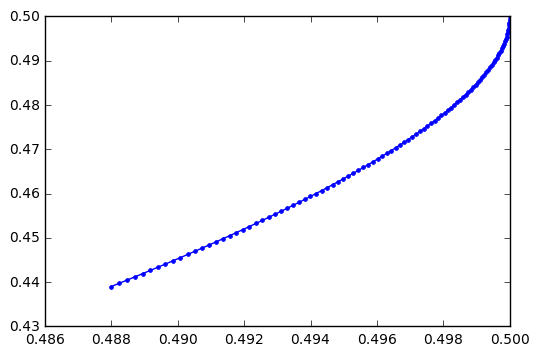

In [40]:
tsample = np.linspace(ts[0], ts[-1] - 0.001, 100)
plot([qcom(t)[0] for t in tsample], [qcom(t)[1] for t in tsample], "b.-")

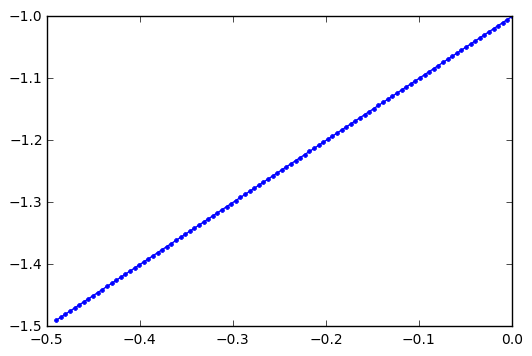

In [41]:
plot([vcom(t)[0] for t in tsample], [vcom(t)[1] for t in tsample], "b.-")

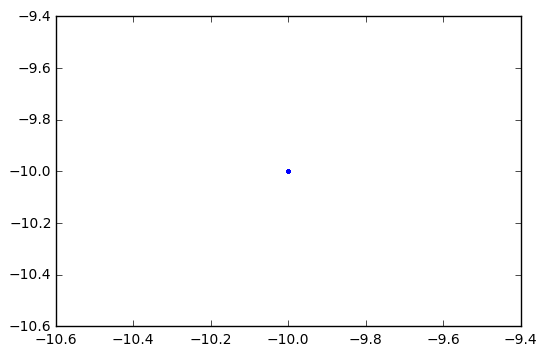

In [42]:
plot([acom(t)[0] for t in tsample], [acom(t)[1] for t in tsample], "b.-")